In [1]:
with open('shakespeare.txt') as file:
    corpus = file.read()

In [2]:
print(corpus[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [3]:
import string
import torch
import numpy as np
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
import re
# \w+|\d+|\n\s*|\s+|
patt = rf"\n|\s?\w+|\d+|\s|'t|'ve|'ll|'s|'d|[{string.punctuation}]+"

tokenized = re.findall(patt, corpus)
print(tokenized[:100])

['First', ' Citizen', ':', '\n', 'Before', ' we', ' proceed', ' any', ' further', ',', ' hear', ' me', ' speak', '.', '\n', '\n', 'All', ':', '\n', 'Speak', ',', ' speak', '.', '\n', '\n', 'First', ' Citizen', ':', '\n', 'You', ' are', ' all', ' resolved', ' rather', ' to', ' die', ' than', ' to', ' famish', '?', '\n', '\n', 'All', ':', '\n', 'Resolved', '.', ' resolved', '.', '\n', '\n', 'First', ' Citizen', ':', '\n', 'First', ',', ' you', ' know', ' Caius', ' Marcius', ' is', ' chief', ' enemy', ' to', ' the', ' people', '.', '\n', '\n', 'All', ':', '\n', 'We', ' know', "'t", ',', ' we', ' know', "'t", '.', '\n', '\n', 'First', ' Citizen', ':', '\n', 'Let', ' us', ' kill', ' him', ',', ' and', ' we', "'ll", ' have', ' corn', ' at', ' our', ' own']


In [5]:
vocabulary = sorted(set(tokenized))
print(len(vocabulary))
stoi = {s:i for i,s in enumerate(vocabulary)}
itos = {i:s for i,s in enumerate(vocabulary)}

15052


In [6]:
encoded_corpus = [stoi[tok] for tok in tokenized]

In [7]:
k = int(len(encoded_corpus)*0.9)
train_corpus = encoded_corpus[:k]
val_corpus = encoded_corpus[k:]

In [8]:
class DataLoader:
    def __init__(self, corpus, block_size) -> None:
        self.curr_pos = 0
        self.corpus = torch.tensor(corpus)
        self.examples_index = list(range(0, len(corpus)-block_size-1, block_size))
        self.order = np.random.permutation(self.examples_index)
        self.block_size = block_size
        self.stride = 0

    def get_batch(self, batch_size):
        batch_examples = self.order[self.curr_pos:self.curr_pos+batch_size]
        self.curr_pos += len(batch_examples)
        
        if len(batch_examples) < batch_size:
            self.curr_pos = 0
            self.stride = (self.stride + 1) % self.block_size
            self.examples_index = list(range(self.stride, len(self.corpus)-self.block_size-1, self.block_size))
            self.order = np.random.permutation(self.examples_index)
            if  len(batch_examples) == 0:
                batch_examples = self.order[self.curr_pos:self.curr_pos+batch_size]
                self.curr_pos += len(batch_examples)
        
        
        x = torch.stack([self.corpus[idx:idx+self.block_size] for idx in batch_examples], dim=0)
        y = torch.stack([self.corpus[idx+1:idx+1+self.block_size] for idx in batch_examples], dim=0)
        return x, y

In [9]:
data = DataLoader(encoded_corpus[:100], 4)

In [10]:
print('curr_pos', data.curr_pos)
x, y = data.get_batch(5)
decode = lambda x: [itos[s.item()] for s in x]
print(x.shape, y.shape)

for i in range(5):
    context = decode(x[i])
    target = decode([y[i][-1]])
    print(f'context: {context} -> {target}')

curr_pos 0
torch.Size([5, 4]) torch.Size([5, 4])
context: [' and', ' we', "'ll", ' have'] -> [' corn']
context: ['.', '\n', '\n', 'First'] -> [' Citizen']
context: ['\n', 'First', ' Citizen', ':'] -> ['\n']
context: ['First', ' Citizen', ':', '\n'] -> ['Before']
context: [',', ' we', ' know', "'t"] -> ['.']


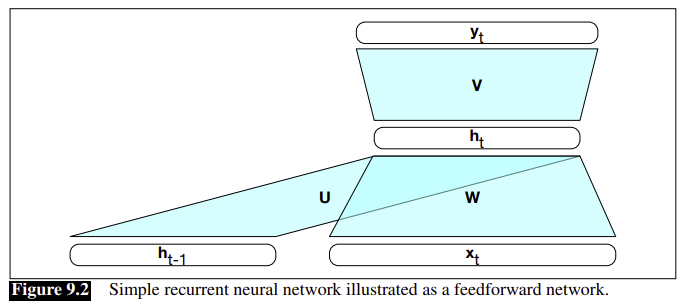

In [11]:
import torch

In [58]:
block_size = 8
train_data = DataLoader(train_corpus, block_size)

In [13]:
x, y = train_data.get_batch(32)

In [14]:
decode = lambda x: [itos[s.item()] for s in x]
print(x.shape, y.shape)

for i in range(4):
    context = decode(x[i])
    target = decode([y[i][-1]])
    print(f'context: {context} -> {target}')

torch.Size([32, 8]) torch.Size([32, 8])
context: [' hath', ' lost', ' his', ' holy', ' honour', ';', '\n', 'The'] -> [' garter']
context: [' dreams', ',', '\n', 'To', ' set', ' my', ' brother', ' Clarence'] -> [' and']
context: [' my', ' fellow', ' Tranio', ' stolen', ' your', ' clothes', '?', ' Or'] -> ['\n']
context: ['Or', ' hoop', ' his', ' body', ' more', ' with', ' thy', ' embraces'] -> [',']


In [15]:
x.shape, y.shape

(torch.Size([32, 8]), torch.Size([32, 8]))

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
vocab_size = len(vocabulary)
embed_dim = 128
batch_size = 512
hidden_layer = 2048
context = block_size

class SimpleRNN(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.E = torch.nn.Parameter(torch.randn((vocab_size, embed_dim)))
        self.W = torch.nn.Parameter(torch.randn((embed_dim, hidden_layer)) * embed_dim**-0.5)
        self.wb = torch.nn.Parameter(torch.zeros((hidden_layer,)))
        self.U = torch.nn.Parameter(torch.randn((hidden_layer, hidden_layer)) * hidden_layer**-0.5)
        self.ub = torch.nn.Parameter(torch.zeros((hidden_layer,)))
        self.V = torch.nn.Parameter(torch.randn((hidden_layer, vocab_size)) * hidden_layer**-0.5)
        # self.dropouts = torch.nn.ModuleList([torch.nn.Dropout() for _ in range(block_size)])
        # self.dropouts2 = torch.nn.ModuleList([torch.nn.Dropout() for _ in range(block_size-1)])
        # self.dropout3 = torch.nn.Dropout()
        # self.W2 = torch.nn.Parameter(torch.randn((hidden_layer, 1024)) * hidden_layer**-0.5)
        # self.w2b = torch.nn.Parameter(torch.zeros((1024, )))
        # self.V = torch.nn.Parameter(torch.randn((1024, vocab_size)) * 1024**-0.5)

    # def parameters(self) -> list[torch.tensor]:
    #     return [self.E, self.W, self.wb, self.U, self.ub, self.V]

    def forward(self, x): # x -> [32, 4]
        # print(x.shape)
        xt = self.E[x] # [32, 4, 64]
        # print(xt.shape)
        previous_h = None
        # y_preds = torch.zeros(x.shape[0], x.shape[1], vocab_size, device=device)
        hts = torch.zeros(x.shape[0], x.shape[1], hidden_layer, device=device)
        for i in range(x.shape[1]): # Iterate over the number of tokens
            ht = xt[:,i,:] @ self.W + self.wb # [32, 64] @ [64, 512] + [512] = [32, 512]
            if previous_h is not None:
                # from_memory = torch.nn.functional.relu(previous_h @ self.U + self.ub) # [32, 512] @ [512, 512] + [512] = [32, 512]
                from_memory = previous_h @ self.U + self.ub # [32, 512] @ [512, 512] + [512] = [32, 512]
                # from_memory = self.dropouts2[i-1](from_memory)
                ht = ht + from_memory # [32, 512]
            ht = torch.nn.functional.relu(ht)
            # ht = self.dropouts[i](ht)
            previous_h = ht # Save hidden state, this is an input for the next word
            # print(ht.shape)
            # yt = ht @ self.V # [32, 512] @ [512, vocab_size] = [32, vocab_size]
            # y_preds[:,i] = yt # Save the prediction for each of the words
            # print(yt.shape)
            hts[:,i] = ht
        y_preds = hts @ self.V # [batch_size, block_size, hidden_dim] @ [hidden_dim, vocab_size] = [batch_size, block_size, vocab_size]
        # hidden_state = self.dropout3(torch.nn.functional.relu(hts @ self.W2 + self.w2b))
        # y_preds = hidden_state @ self.V
        return y_preds # [32, 4, vocab_size]


In [59]:
# WEIGHT TYING
vocab_size = len(vocabulary)
embed_dim = 1024
batch_size = 512
hidden_layer = 1024
context = block_size

class SimpleRNN(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # self.E = torch.nn.Parameter(torch.randn((vocab_size, embed_dim)))
        self.W = torch.nn.Parameter(torch.randn((embed_dim, hidden_layer)) * embed_dim**-0.5)
        self.wb = torch.nn.Parameter(torch.zeros((hidden_layer,)))
        self.U = torch.nn.Parameter(torch.randn((hidden_layer, hidden_layer)) * hidden_layer**-0.5)
        self.ub = torch.nn.Parameter(torch.zeros((hidden_layer,)))
        self.V = torch.nn.Parameter(torch.randn((hidden_layer, vocab_size)) * hidden_layer**-0.5)
        # self.dropouts = torch.nn.ModuleList([torch.nn.Dropout() for _ in range(block_size)])
        # self.dropouts2 = torch.nn.ModuleList([torch.nn.Dropout() for _ in range(block_size-1)])
        # self.dropout3 = torch.nn.Dropout()
        # self.W2 = torch.nn.Parameter(torch.randn((hidden_layer, 1024)) * hidden_layer**-0.5)
        # self.w2b = torch.nn.Parameter(torch.zeros((1024, )))
        # self.V = torch.nn.Parameter(torch.randn((1024, vocab_size)) * 1024**-0.5)

    # def parameters(self) -> list[torch.tensor]:
    #     return [self.E, self.W, self.wb, self.U, self.ub, self.V]

    def forward(self, x): # x -> [32, 4]
        # print(x.shape)
        # xt = self.E[x] # [32, 4, 64]
        xt = self.V.transpose(0,1)[x]
        # print(xt.shape)
        previous_h = None
        # y_preds = torch.zeros(x.shape[0], x.shape[1], vocab_size, device=device)
        hts = torch.zeros(x.shape[0], x.shape[1], hidden_layer, device=device)
        for i in range(x.shape[1]): # Iterate over the number of tokens
            ht = xt[:,i,:] @ self.W + self.wb # [32, 64] @ [64, 512] + [512] = [32, 512]
            if previous_h is not None:
                # from_memory = torch.nn.functional.relu(previous_h @ self.U + self.ub) # [32, 512] @ [512, 512] + [512] = [32, 512]
                from_memory = previous_h @ self.U + self.ub # [32, 512] @ [512, 512] + [512] = [32, 512]
                # from_memory = self.dropouts2[i-1](from_memory)
                ht = ht + from_memory # [32, 512]
            ht = torch.nn.functional.relu(ht)
            # ht = self.dropouts[i](ht)
            previous_h = ht # Save hidden state, this is an input for the next word
            # print(ht.shape)
            # yt = ht @ self.V # [32, 512] @ [512, vocab_size] = [32, vocab_size]
            # y_preds[:,i] = yt # Save the prediction for each of the words
            # print(yt.shape)
            hts[:,i] = ht
        y_preds = hts @ self.V # [batch_size, block_size, hidden_dim] @ [hidden_dim, vocab_size] = [batch_size, block_size, vocab_size]
        # hidden_state = self.dropout3(torch.nn.functional.relu(hts @ self.W2 + self.w2b))
        # y_preds = hidden_state @ self.V
        return y_preds # [32, 4, vocab_size]

In [19]:
# Baseline loss
-torch.log(torch.tensor(1)/vocab_size)

tensor(9.6193)

In [20]:
steps_per_epoch = int(len(train_data.corpus) / (batch_size * block_size))
steps_per_epoch

65

In [60]:
train_eval = DataLoader(train_corpus, block_size)
val_eval = DataLoader(val_corpus, block_size)

@torch.no_grad
def estimate_loss(model: torch.nn.Module, train_eval: DataLoader, val_eval: DataLoader, batch_size: int = 256, eval_iters: int = 10):
    model.eval()
    train_losses = []
    val_losses = []
    for i in range(eval_iters):
        x, y = train_eval.get_batch(batch_size)
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = torch.nn.functional.cross_entropy(y_pred.view(-1, vocab_size), y.view(-1))
        train_losses.append(loss.item())

        x, y = val_eval.get_batch(batch_size)
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = torch.nn.functional.cross_entropy(y_pred.view(-1, vocab_size), y.view(-1))
        val_losses.append(loss.item())
    train_loss = sum(train_losses)/eval_iters
    val_loss = sum(val_losses)/eval_iters

    model.train()
    return train_loss, val_loss

rnn = SimpleRNN()

In [22]:
sum([p.nelement() for p in rnn.parameters()])

17512448

In [23]:
rnn.to(device)
learning_rate = 0.005

train_losses = []
val_losses = []

# Training loop
# for p in rnn.parameters():
#     p.requires_grad = True
rnn.train()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate, weight_decay=0.001)

max_steps = 20*steps_per_epoch
print(f'Training for {max_steps} steps')
for step in range(max_steps):
    x, y = train_data.get_batch(batch_size)
    x, y = x.to(device), y.to(device)
    y_pred = rnn.forward(x)
    loss = torch.nn.functional.cross_entropy(y_pred.view(-1, vocab_size), y.view(-1))

    # Clean the gradients
    # for p in rnn.parameters():
    #     p.grad = None
    optimizer.zero_grad()
    loss.backward()
    # Update parameters
    optimizer.step()
    # for p in rnn.parameters():
    #     p.data -= learning_rate * p.grad

    # Logs
    if (step+1) % 100 == 0 or step == 0 or step == max_steps-1:
        train_loss, valid_loss = estimate_loss(rnn)
        print(f'Step {step+1:4d} - Train loss: {train_loss:4.2f} - Valid loss: {valid_loss:4.2f}')
        train_losses.append(train_loss)
        val_losses.append(valid_loss)

Training for 1300 steps
Step    1 - Train loss: 10.07 - Valid loss: 10.07
Step  100 - Train loss: 5.24 - Valid loss: 5.38
Step  200 - Train loss: 5.04 - Valid loss: 5.05
Step  300 - Train loss: 4.93 - Valid loss: 5.05
Step  400 - Train loss: 4.92 - Valid loss: 5.04
Step  500 - Train loss: 4.87 - Valid loss: 5.05
Step  600 - Train loss: 4.86 - Valid loss: 5.00
Step  700 - Train loss: 4.91 - Valid loss: 5.00
Step  800 - Train loss: 4.87 - Valid loss: 4.98
Step  900 - Train loss: 4.84 - Valid loss: 4.97
Step 1000 - Train loss: 4.82 - Valid loss: 4.98
Step 1100 - Train loss: 4.78 - Valid loss: 4.96
Step 1200 - Train loss: 4.85 - Valid loss: 4.98
Step 1300 - Train loss: 4.85 - Valid loss: 4.97


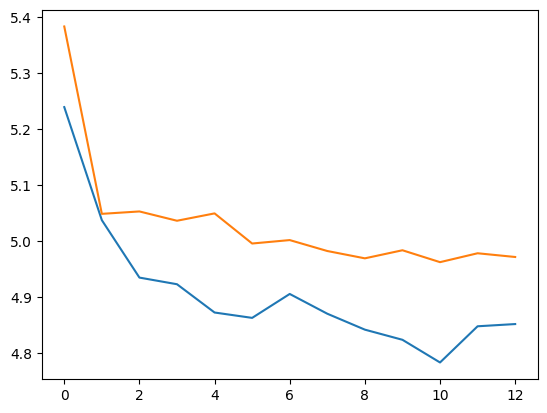

In [24]:
import matplotlib.pyplot as plt

plt.plot(train_losses[1:])
plt.plot(val_losses[1:])

In [64]:
class TorchRNN(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.EmbedLayer = torch.nn.Embedding(vocab_size, embed_dim)
        self.rnn = torch.nn.RNN(embed_dim, hidden_layer, batch_first=True, dropout=0.5, nonlinearity='relu')
        self.dense = torch.nn.Linear(hidden_layer, vocab_size, bias=False)

    def forward(self, x):
        embeds = self.EmbedLayer(x)
        output, ht = self.rnn(embeds)
        logits = self.dense(output)
        return logits
    
rnn = TorchRNN()

/home/manuel/projects/neural_networks_experiments/.venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [65]:
sum([p.nelement() for p in rnn.parameters()])

17492736

In [66]:
rnn.to(device)

train_losses = []
val_losses = []

# Training loop
# for p in rnn.parameters():
#     p.requires_grad = True
rnn.train()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

print(f'Training for {max_steps} steps')
for step in range(max_steps):
    x, y = train_data.get_batch(batch_size)
    x, y = x.to(device), y.to(device)
    y_pred = rnn(x)
    loss = torch.nn.functional.cross_entropy(y_pred.view(-1, vocab_size), y.view(-1))

    # Clean the gradients
    # for p in rnn.parameters():
    #     p.grad = None
    optimizer.zero_grad()
    loss.backward()
    # Update parameters
    optimizer.step()
    # for p in rnn.parameters():
    #     p.data -= learning_rate * p.grad

    # Logs
    if (step+1) % 100 == 0 or step == 0 or step == max_steps-1:
        train_loss, valid_loss = estimate_loss(rnn)
        print(f'Step {step+1:4d} - Train loss: {train_loss:4.2f} - Valid loss: {valid_loss:4.2f}')
        train_losses.append(train_loss)
        val_losses.append(valid_loss)

Training for 650 steps
Step    1 - Train loss: 6111.06 - Valid loss: 6299.16
Step  100 - Train loss: 4.95 - Valid loss: 5.43
Step  200 - Train loss: 4.48 - Valid loss: 5.35
Step  300 - Train loss: 4.12 - Valid loss: 5.41
Step  400 - Train loss: 3.77 - Valid loss: 5.56
Step  500 - Train loss: 3.55 - Valid loss: 5.75
Step  600 - Train loss: 3.50 - Valid loss: 5.81
Step  650 - Train loss: 3.45 - Valid loss: 5.94


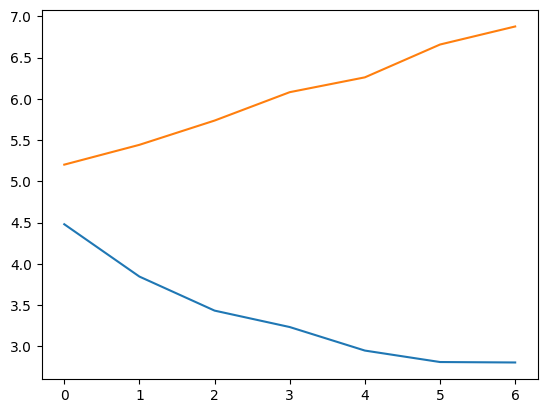

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses[1:])
plt.plot(val_losses[1:])

In [32]:
@torch.no_grad
def generate(model, seed: torch.tensor, max_tokens = 200, max_context = block_size):
    model.eval()
    generation = seed.clone().to(device)
    for i in range(max_tokens):
        pred = model(generation[:,-max_context:])
        pred = pred[:,-1,:] # Only take the prediction for the last word
        probs = torch.nn.functional.softmax(pred, dim=-1)
        next_tok = torch.multinomial(probs, 1)
        generation = torch.cat((generation, next_tok), dim=1)
    return ''.join(decode(generation[0]))

In [26]:
seed = torch.tensor([[stoi['\n']]])
print(generate(rnn, seed))


Lieutenant ports she paw to Warwick? for the stay like this?

Nurse:
 mad.

LUCIO:
AUFIDIUS; at this that himself sacrament
March, a provoke horse love reposing.

ESCALUS:
How say hath hold foot to them.
You see I am, Emilia rest, advanced,
And mourn that himself will mercy the VINCENTIO of my life?
And all a love inquired sedition.

SAMPSON:
Be's happy time, assign! What
Than minstrels our house! whose ValentineConceive,
Topurse ram spirit with mine.
And most their discreetly. what soul of him?

First ANNE:
His Lady shall come of friends, though stooping
Examine, as I thou say.

 rear:
Some, go not best true: when Willoughby- people,
But on haughty's pleasure?
en home how sugar hither weeping virtue to seeks,
Which uncles done in any; and we take
any general of


## Stacked RNNs

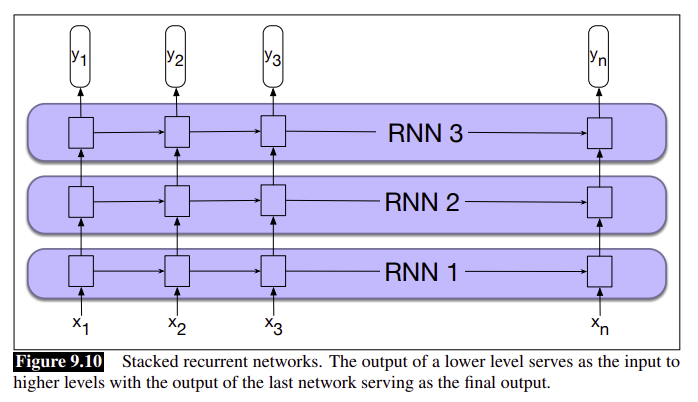

In [69]:
class StackedRNNs(torch.nn.Module):
    def __init__(self, stacked_layers_num, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.EmbedLayer = torch.nn.Embedding(vocab_size, embed_dim)
        self.stacked_rnn = torch.nn.RNN(embed_dim, hidden_layer, batch_first=True, dropout=0.5, nonlinearity='relu', num_layers=stacked_layers_num)
        self.dense = torch.nn.Linear(hidden_layer, vocab_size, bias=False)

    def forward(self, x):
        embeds = self.EmbedLayer(x)
        output, ht = self.stacked_rnn(embeds)
        logits = self.dense(output)
        return logits
    
model = StackedRNNs(3)

In [70]:
model.to(device)
learning_rate = 0.001

train_losses = []
val_losses = []

# Training loop
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

print(f'Training for {max_steps} steps')
for step in range(max_steps):
    x, y = train_data.get_batch(batch_size)
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = torch.nn.functional.cross_entropy(y_pred.view(-1, vocab_size), y.view(-1))

    # Clean the gradients
    optimizer.zero_grad()
    # Calculate the gradient
    loss.backward()
    # Update parameters
    optimizer.step()

    # Logs
    if (step+1) % 100 == 0 or step == 0 or step == max_steps-1:
        train_loss, valid_loss = estimate_loss(model, train_eval, val_eval)
        print(f'Step {step+1:4d} - Train loss: {train_loss:4.2f} - Valid loss: {valid_loss:4.2f}')
        train_losses.append(train_loss)
        val_losses.append(valid_loss)

Training for 1300 steps
Step    1 - Train loss: 8.76 - Valid loss: 8.69
Step  100 - Train loss: 5.30 - Valid loss: 5.41
Step  200 - Train loss: 4.94 - Valid loss: 5.16
Step  300 - Train loss: 4.72 - Valid loss: 5.00
Step  400 - Train loss: 4.66 - Valid loss: 4.93
Step  500 - Train loss: 4.57 - Valid loss: 4.90
Step  600 - Train loss: 4.52 - Valid loss: 4.90
Step  700 - Train loss: 4.44 - Valid loss: 4.90
Step  800 - Train loss: 4.43 - Valid loss: 4.87
Step  900 - Train loss: 4.38 - Valid loss: 4.87
Step 1000 - Train loss: 4.38 - Valid loss: 4.87
Step 1100 - Train loss: 4.38 - Valid loss: 4.84
Step 1200 - Train loss: 4.31 - Valid loss: 4.86
Step 1300 - Train loss: 4.30 - Valid loss: 4.84


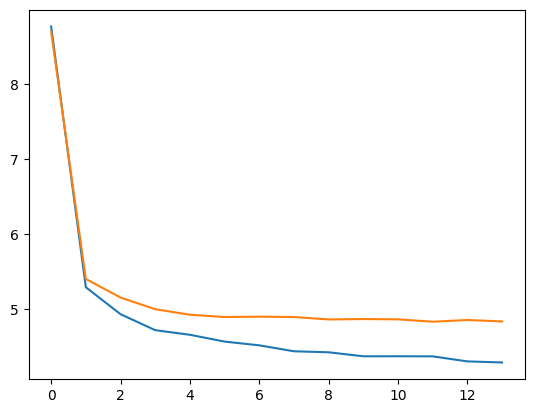

In [71]:
plt.plot(train_losses)
plt.plot(val_losses)

In [72]:
seed = torch.tensor([[stoi['\n']]])
print(generate(model, seed))


GLOUCESTER:
Amen, andInfuse't ladyship to the king, blue too pitiful:
That stagger off sometime merry; and in my wife!

GLOUCESTER:
Say? what has? what is his voices
That those mayor hath a gate and resort's deliciousness,
You do have woollen.

DUKE OF YORK:
Here am brave fell and shade to ask.

HENRY BOLINGBROKE:
Go thither, enough the chiefest liver.

WARWICK:
You are but then would I marry with thee.
Come makes, Cominius's subject, strew it were.

AUTOLYCUS:
No, no wife!
That then the true full o' enemies,
Some stark of their answered till I do
 Are of child and share your honour:
So but,thoroughly, presentDidst he approbation'd so water you.

COMINIUS:
You must not live; but these another Minola.
The day the love will bid
Unto my need from happiness.


## LSTMs

In [111]:
block_size = 16
vocab_size = len(vocabulary)
embed_dim = 1024
batch_size = 512
hidden_layer = 1024

train_data = DataLoader(train_corpus, block_size)
train_eval = DataLoader(train_corpus, block_size)
val_eval = DataLoader(val_corpus, block_size)

In [116]:
class LSTM(torch.nn.Module):
    def __init__(self, stacked_layers_num, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.EmbedLayer = torch.nn.Embedding(vocab_size, embed_dim)
        self.lstm = torch.nn.LSTM(embed_dim, hidden_layer, batch_first=True, dropout=0.5, num_layers=stacked_layers_num)
        self.dense = torch.nn.Linear(hidden_layer, vocab_size, bias=False)

    def forward(self, x):
        embeds = self.EmbedLayer(x)
        output, ht = self.lstm(embeds)
        logits = self.dense(output)
        return logits
    
model = LSTM(3)

In [120]:
# Training loop
def training_loop(model, lr, max_steps, data_loader: DataLoader, train_eval: DataLoader, val_eval: DataLoader, weight_decay: float = 0.0):
    train_losses = []
    val_losses = []

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    print(f'Training for {max_steps} steps')
    for step in range(max_steps):
        x, y = data_loader.get_batch(batch_size)
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = torch.nn.functional.cross_entropy(y_pred.view(-1, vocab_size), y.view(-1))

        # Clean the gradients
        optimizer.zero_grad()
        # Calculate the gradient
        loss.backward()
        # Update parameters
        optimizer.step()

        # Logs
        if (step+1) % 100 == 0 or step == 0 or step == max_steps-1:
            train_loss, valid_loss = estimate_loss(model, train_eval, val_eval)
            print(f'Step {step+1:4d} - Train loss: {train_loss:4.2f} - Valid loss: {valid_loss:4.2f}')
            train_losses.append(train_loss)
            val_losses.append(valid_loss)
    return train_losses, val_losses

In [121]:
steps_per_epoch = int(len(train_data.corpus) / (batch_size * block_size))
steps_per_epoch

32

In [122]:
model.to(device)
learning_rate = 0.002
train_losses, val_losses = training_loop(model, learning_rate, steps_per_epoch*20, train_data, train_eval, val_eval, weight_decay=0.0001)

Training for 640 steps
Step    1 - Train loss: 3.96 - Valid loss: 5.22
Step  100 - Train loss: 3.56 - Valid loss: 4.77
Step  200 - Train loss: 3.57 - Valid loss: 4.80
Step  300 - Train loss: 3.56 - Valid loss: 4.77
Step  400 - Train loss: 3.42 - Valid loss: 4.76
Step  500 - Train loss: 3.34 - Valid loss: 4.77
Step  600 - Train loss: 3.37 - Valid loss: 4.72
Step  640 - Train loss: 3.38 - Valid loss: 4.75


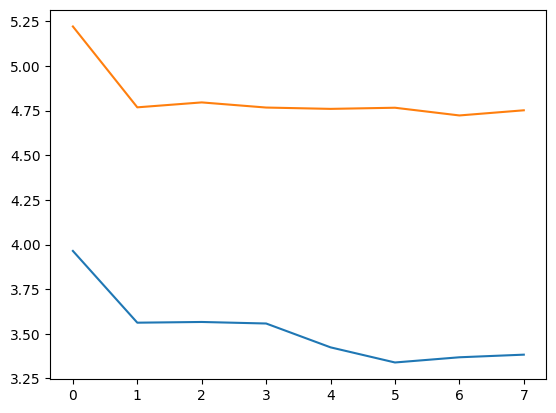

In [123]:
plt.plot(train_losses)
plt.plot(val_losses)

In [124]:
seed = torch.tensor([[stoi['\n']]])
print(generate(model, seed))


His superfluity: yet she was drunk she's images!
And, with this crow, hence of our charge,
And watch me scaled plain danger,
Which you do had been, like a most most present day,
Or could sell unrestrained that were commanded
A greater new-Plays- Cambio's quite.
And follow him too late; and one she may be strong
In bed and lane's disadvantage, I'll bring.
CLARENCE:

WARWICK:
With such a lustful heart twinkle out the moon,
 discoveries of Gaunt, this wretch, calendar nap,
More conduct to this palsy wretch delights,
 Franciscan Phoebus'er one be condemned well fool!
What will I learn?
More than my will be humble was a happy of.
Boy, stay your lordship!

DUCHESS OF YORK:
O morrow, dear!

JULIET:
O God, my son told me so evil,
Though may be so forgiveness, here's nobody
